In [1]:
# Standard Python imports
import os
import copy
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Astropy imports
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch
import astropy.io.fits as pyfits

# Lenstronomy imports
import lenstronomy
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import kernel_util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence

name='J2325-5229'

# Prepare F814W Data

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_87516/4280210388.py:15: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


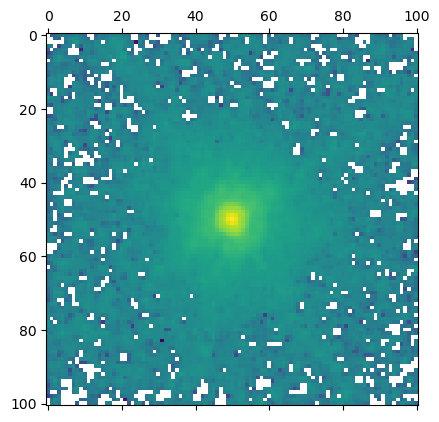

In [2]:
# load F814W PSF data
psf_file = f'../../cutout_data/{name}/F814W/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf1 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3}
psf_class = PSF(**kwargs_psf1)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [3]:
# Open the FITS file and extract the header
filename = f'../../cutout_data/{name}/F814W/{name}_F814W_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.04  # size of UVIS pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

In [4]:
# set up data class
kwargs_data1 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics1 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

# Prepare F475X Data

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_87516/1724922828.py:15: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


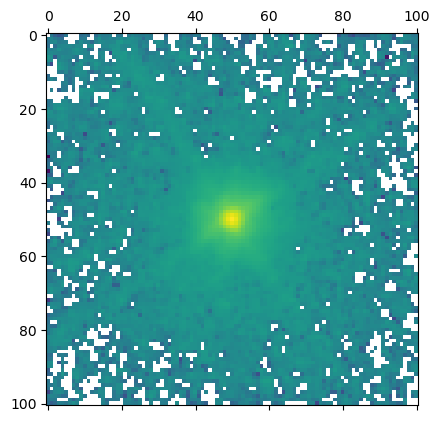

In [5]:
# load F475X PSF data
psf_file = f'../../cutout_data/{name}/F475X/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf2 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3}
psf_class = PSF(**kwargs_psf2)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [6]:
# Open the FITS file and extract the header
filename = f'../../cutout_data/{name}/F475X/{name}_F475X_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.04  # size of UVIS pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data2 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics2 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

# Prepare F160W Data

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_87516/3229314060.py:15: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


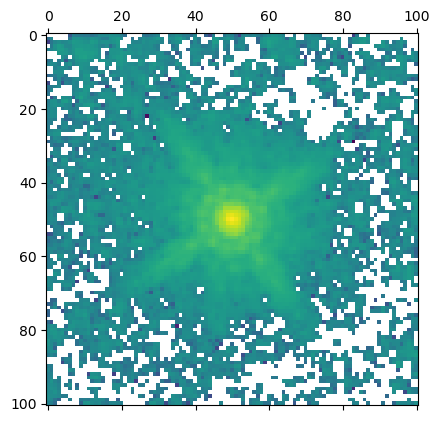

In [7]:
# load F475X PSF data
psf_file = f'../../cutout_data/{name}/F160W/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf3 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3}
psf_class = PSF(**kwargs_psf3)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [8]:
# Open the FITS file and extract the header
filename = f'../../cutout_data/{name}/F160W/{name}_F160W_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.08  # size of IR pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data3 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics3 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_87516/4156211883.py:10: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


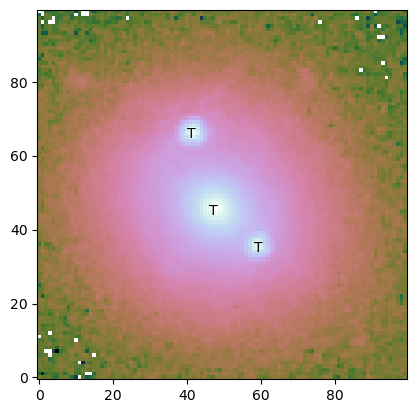

In [9]:
# display science image and obtain coordinates of point source and lens centers
x1, y1 = 40, 65
x2, y2 = 46, 44
x3, y3 = 58, 34

plt.annotate('T', [x1,y1], color='black')
plt.annotate('T', [x2,y2], color='black')
plt.annotate('T', [x3,y3], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')

im1 = pixel_grid.map_pix2coord(x1, y1)

lens_pos = pixel_grid.map_pix2coord(x2,y2)

im2 = pixel_grid.map_pix2coord(x3,y3)

In [10]:
# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]
# image coordinates #
im1_x, im1_y = im1[0], im1[1]
im2_x, im2_y = im2[0], im2[1]

# calculate the initial guess for theta_E as half the image separation
einstein_rad = np.sqrt((im2_x - im1_x)**2 + (im2_y - im1_y)**2) / 2
print(f'Initial guess for theta_E: {einstein_rad}')

# set up point source and lens positions
theta_ra = np.array([im1_x, im2_x])
theta_dec = np.array([im1_y, im2_y])

Initial guess for theta_E: 1.4338758663147935


In [11]:
# model parameters, applicaple for both bands

lens_model_list = ['EPL', 'SHEAR']

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

source_model_list = ['SERSIC_ELLIPSE']

point_source_list = ['LENSED_POSITION']

# set up model arguments

kwargs_model = {'lens_model_list': lens_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               #'source_light_model_list': source_model_list
                               }


kwargs_constraints = {'num_point_source_list': [2],
                              'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]],
                              'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']]],
                              #'joint_source_with_point_source': [[0, 0]],
                              }

kwargs_likelihood = {'check_bounds': True,
                     #'image_likelihood_mask_list': [mask_img],
                            #'image_position_uncertainty': 0.004,
                      'source_position_likelihood': True,                              
                      'source_position_tolerance': 0.001
                              }

image_band1 = [kwargs_data1, kwargs_psf1, kwargs_numerics1]
image_band2 = [kwargs_data2, kwargs_psf2, kwargs_numerics2]
image_band3 = [kwargs_data3, kwargs_psf3, kwargs_numerics3]
multi_band_list = [image_band3, image_band1, image_band2]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

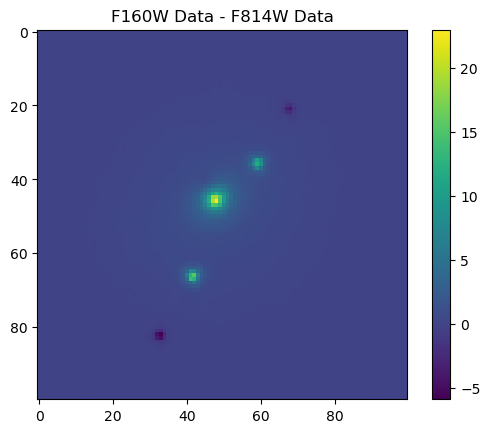

In [12]:
plt.imshow(kwargs_data3['image_data'] - kwargs_data1['image_data'])  # Residual alignment check
plt.title('F160W Data - F814W Data')
plt.colorbar()
plt.show()


In [13]:
# initial guess of non-linear parameters
kwargs_lens_init = [{'theta_E': einstein_rad, 'gamma': 2., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y},
                    {'gamma1': 0., 'gamma2': 0., 'ra_0': 0, 'dec_0': 0}]
kwargs_lens_light_init = [{'R_sersic': 1., 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                          {'R_sersic': 2., 'n_sersic': 4., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y}]

kwargs_source_init = [{'R_sersic': 0.3, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y}]
kwargs_ps_init = [{'ra_image': theta_ra, 'dec_image': theta_dec}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.2, 'gamma': .5, 'e1': .5, 'e2': .5, 'center_x': 0.1, 'center_y': 0.1},
                     {'gamma1': .1, 'gamma2': .1}]
kwargs_lens_light_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1},
                           {'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1}]
kwargs_source_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': .1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 2, 'dec_image': [0.02] * 2}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.01, 'gamma': 1., 'e1': -0.15, 'e2': -0.15, 'center_x': -10., 'center_y': -10},
                     {'gamma1': -0.3, 'gamma2': -0.3}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10},
                           {'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.15, 'e2': -0.15, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(theta_ra), 'dec_image': -10 * np.ones_like(theta_dec)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'gamma': 3., 'e1': 0.15, 'e2': 0.15, 'center_x': 10., 'center_y': 10},
                     {'gamma1': 0.3, 'gamma2': 0.3}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10},
                           {'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10}]
kwargs_upper_source = [{'R_sersic': .5, 'n_sersic': 1.5, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(theta_ra), 'dec_image': 10 * np.ones_like(theta_dec)}]


lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}, {}], kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                 #'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))


Computing the PSO ...


100%|██████████| 100/100 [01:10<00:00,  1.43it/s]
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),


Max iteration reached! Stopping.
-7.180747882751748 reduced X^2 of best position
-35821.1608131071 log likelihood
9977.0 effective number of data points
[{'theta_E': np.float64(1.9248678459590418), 'gamma': 2, 'e1': np.float64(0.1391145979087076), 'e2': np.float64(-0.04375386460702115), 'center_x': np.float64(7.811881305308603), 'center_y': np.float64(-0.3422890439372534)}, {'gamma1': np.float64(0.20443995457101444), 'gamma2': np.float64(0.25478729281581514), 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': np.float64(1.6113833424915889), 'n_sersic': np.float64(0.7110934959578539), 'e1': np.float64(0.04116317362028232), 'e2': np.float64(-0.07563545145920801), 'center_x': np.float64(7.811881305308603), 'center_y': np.float64(-0.3422890439372534)}, {'amp': 1, 'R_sersic': np.float64(0.7005443019636258), 'n_sersic': np.float64(5.952745640972028), 'e1': np.float64(0.032672473438144806), 'e2': np.float64(-0.10128396630493476), 'center_x': np.float64(7.811881305308

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1218: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_87516/1874005366.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


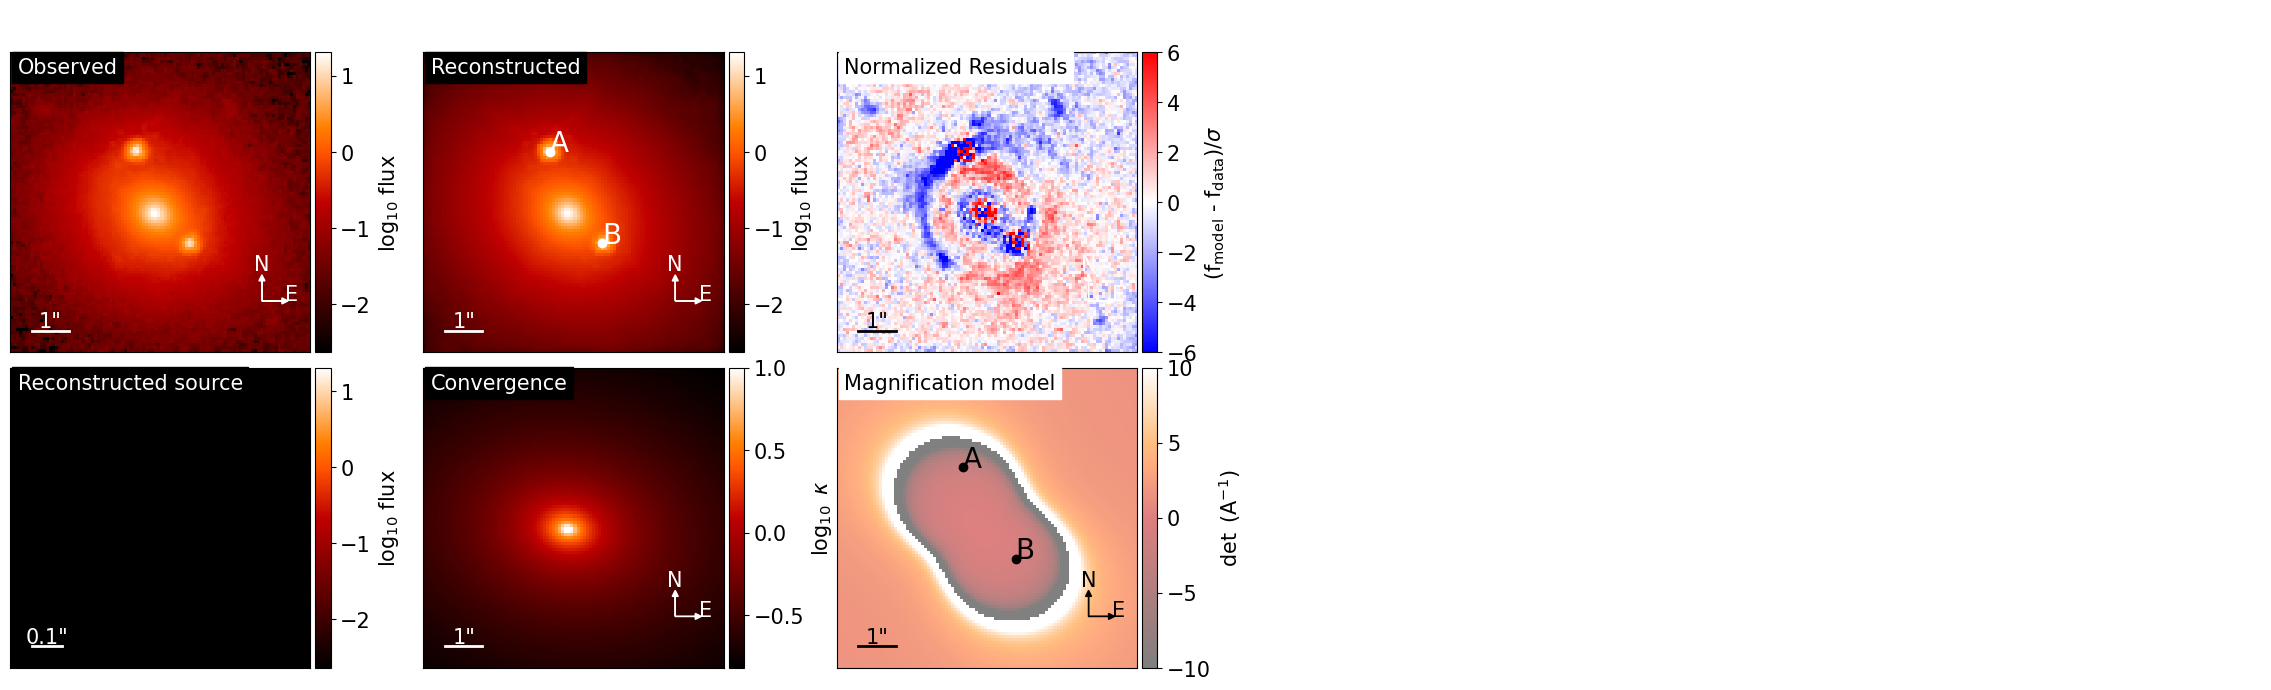

In [14]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, False, False]}}], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],  # run PSO first band
    ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

filter_index = 0
single_band = [multi_band_list[filter_index]]

# Create ModelPlot with single-band list
modelPlot = ModelPlot(single_band, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

# Plot
f, axes = modelPlot.plot_main()
f.show()


Computing the Alignment fitting for band 1 ... ...


 13%|█▎        | 127/1000 [02:30<17:15,  1.19s/it]


Converged after 127 iterations!
Best fit found:  -8184.719528927192 [4.030208309120448, 0.006619636673736261, 0.004599684125076097]
Shifts found:  [4.030208309120448, 0.006619636673736261, 0.004599684125076097]
150.69800686836243 time used for  Alignment fitting for band 1 ...
Align completed for band 1.
ra_shift: 4.030208309120448,  dec_shift: 0.006619636673736261, phi_rot: 0.004599684125076097
Computing the PSO ...


100%|██████████| 100/100 [02:54<00:00,  1.74s/it]
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)


Max iteration reached! Stopping.
-4.329355072625746 reduced X^2 of best position
-43235.104432777014 log likelihood
19973.0 effective number of data points
[{'theta_E': np.float64(1.9246594183053771), 'gamma': 2, 'e1': np.float64(0.1348525287887391), 'e2': np.float64(-0.0446360326150256), 'center_x': np.float64(7.810710904958291), 'center_y': np.float64(-0.3428377157029012)}, {'gamma1': np.float64(0.19977004305681786), 'gamma2': np.float64(0.2533470098136774), 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': np.float64(1.603655510397929), 'n_sersic': np.float64(1.0416203447035628), 'e1': np.float64(0.050558421445917365), 'e2': np.float64(-0.05573887403455637), 'center_x': np.float64(7.810710904958291), 'center_y': np.float64(-0.3428377157029012)}, {'amp': 1, 'R_sersic': np.float64(0.5612303786426618), 'n_sersic': np.float64(5.973916299414215), 'e1': np.float64(0.026489137718731348), 'e2': np.float64(-0.11794613878658851), 'center_x': np.float64(7.81071090495

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_87516/3607623484.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


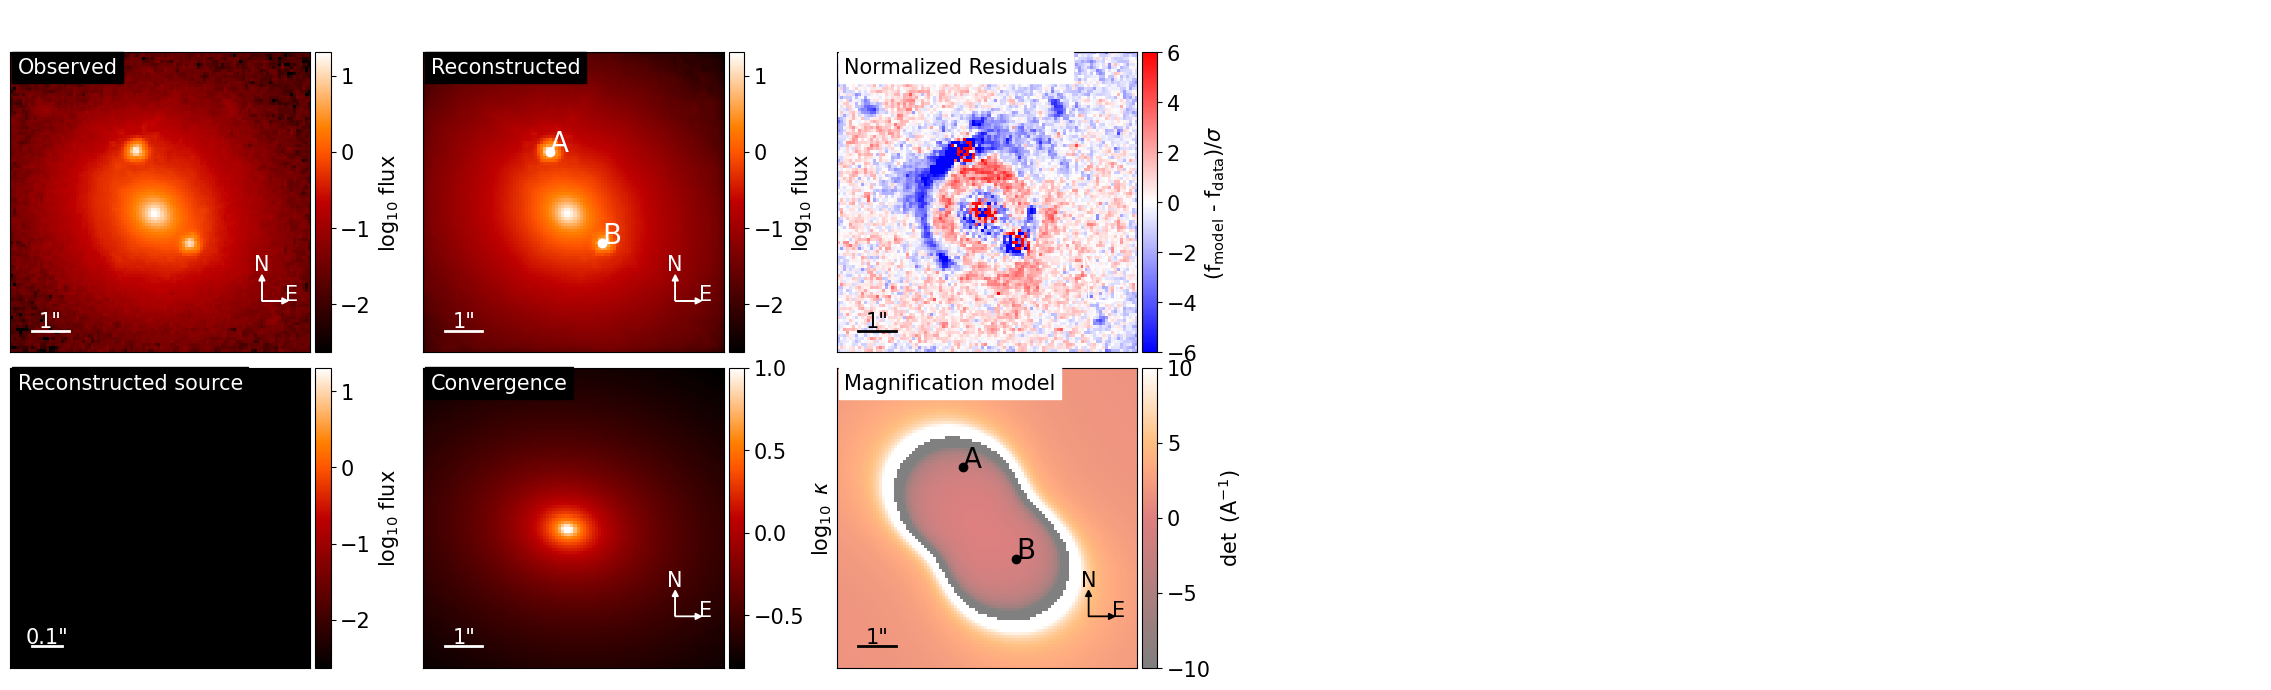

In [15]:
fitting_kwargs_list = [
    ['align_images', {'n_particles': 100, 'n_iterations': 1000, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': 4., 'delta_rot': .1,
                      'compute_bands': [False, True, False]}],  # align second image
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, False]},  # now we fit both bands jointly
                        }], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],  # run PSO of both bands
    ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
new_multiband = fitting_seq.multi_band_list
modelPlot = ModelPlot(new_multiband, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()

-5.2325564425205915 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  5.2325564425205915


/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_87516/4236351963.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


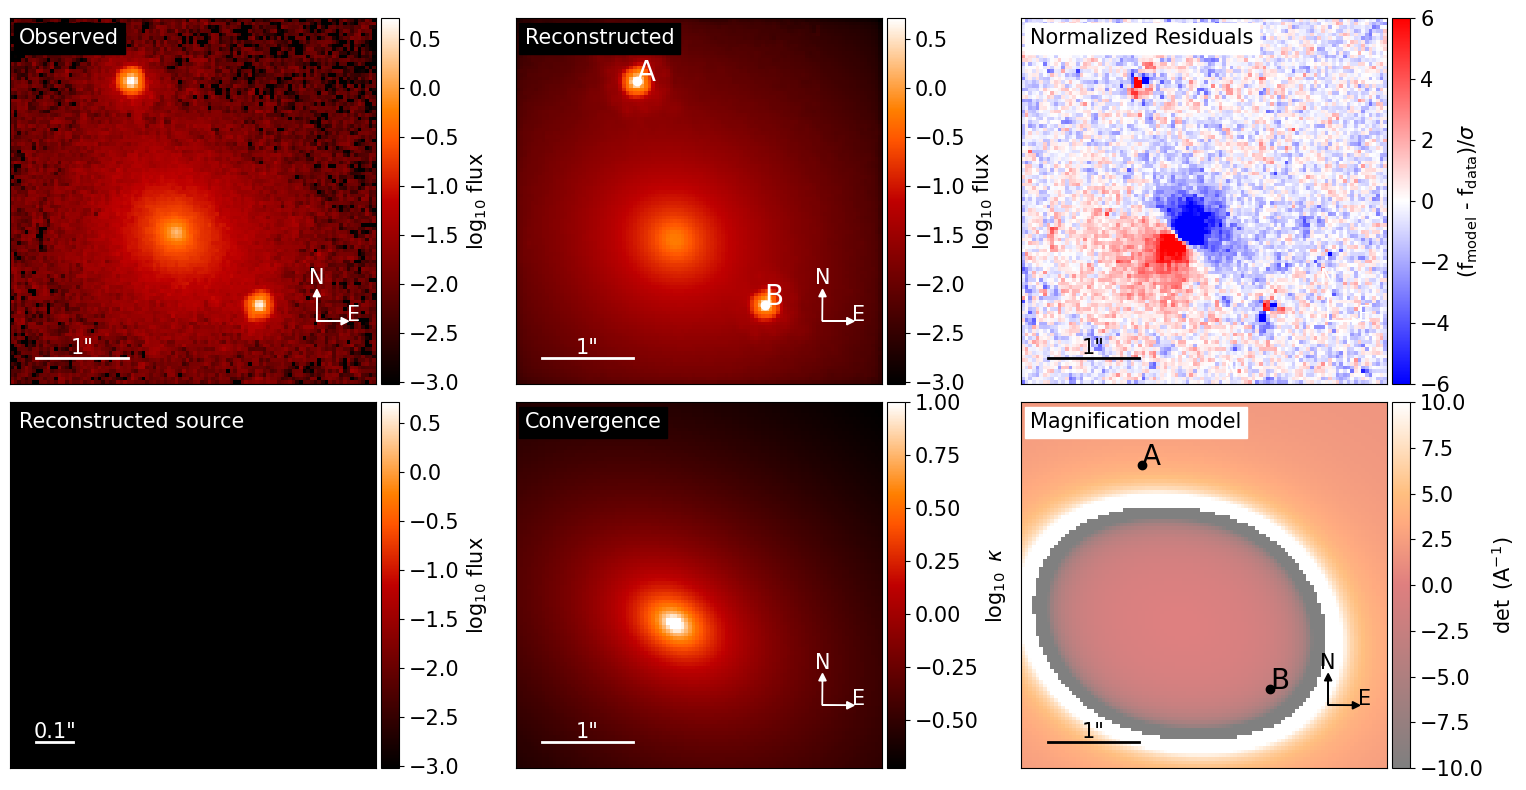

In [21]:
filter_index = 1
single_band = [new_multiband[filter_index]]

# Create ModelPlot with single-band list
modelPlot = ModelPlot(single_band, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

# Plot
f, axes = modelPlot.plot_main()
f.show()

Computing the Alignment fitting for band 2 ... ...


 21%|██        | 210/1000 [02:45<10:23,  1.27it/s]


Converged after 210 iterations!
Best fit found:  -603518.9882265957 [4.153016908793264, -1.65145445771206, -0.07668294847584498]
Shifts found:  [4.153016908793264, -1.65145445771206, -0.07668294847584498]
165.7396068572998 time used for  Alignment fitting for band 2 ...
Align completed for band 2.
ra_shift: 4.153016908793264,  dec_shift: -1.65145445771206, phi_rot: -0.07668294847584498
Computing the PSO ...


100%|██████████| 100/100 [02:56<00:00,  1.77s/it]
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_87516/1733282712.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


Max iteration reached! Stopping.
-85.59878409161969 reduced X^2 of best position
-1282654.9802208752 log likelihood
29969.0 effective number of data points
[{'theta_E': np.float64(1.4356285372388438), 'gamma': 2, 'e1': np.float64(0.0715149833274238), 'e2': np.float64(-0.14152951106036882), 'center_x': np.float64(7.738855790939082), 'center_y': np.float64(-0.4272692026520997)}, {'gamma1': np.float64(-0.04136275155721721), 'gamma2': np.float64(-0.07919500147022318), 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': np.float64(0.004097864695249078), 'n_sersic': np.float64(0.9870288144888951), 'e1': np.float64(0.12343195682574874), 'e2': np.float64(0.14664862041068247), 'center_x': np.float64(7.738855790939082), 'center_y': np.float64(-0.4272692026520997)}, {'amp': 1, 'R_sersic': np.float64(1.1994898281068995), 'n_sersic': np.float64(3.10398709549376), 'e1': np.float64(0.023678906333378116), 'e2': np.float64(-0.042406790810701034), 'center_x': np.float64(7.738855

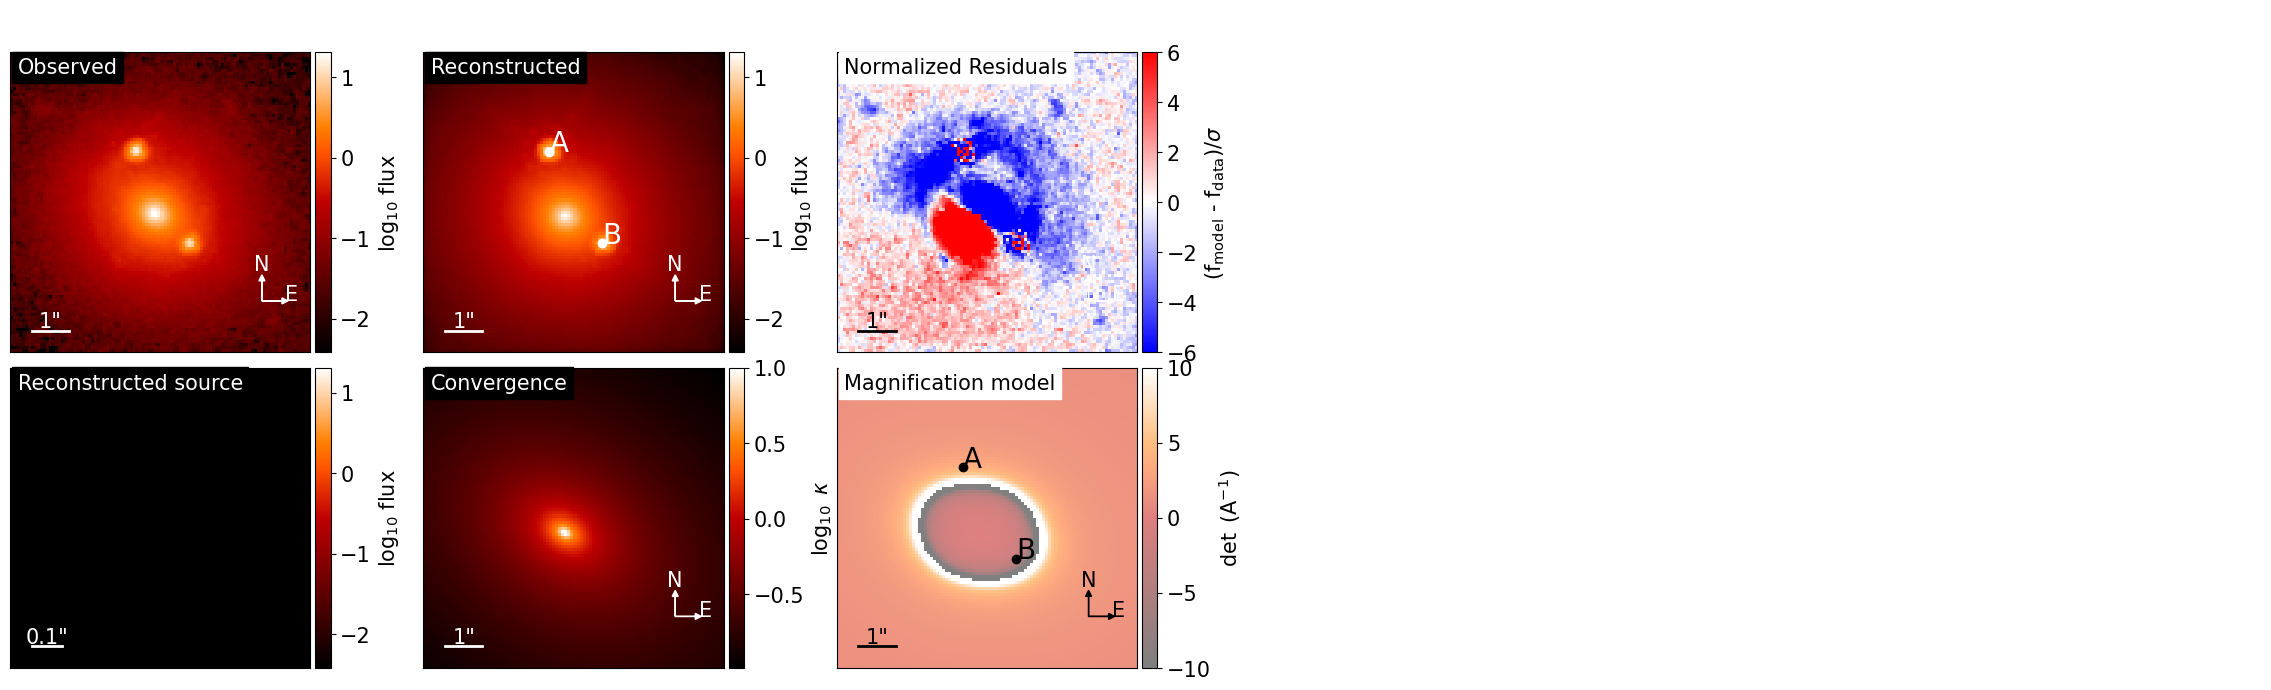

In [16]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [
    ['align_images', {'n_particles': 100, 'n_iterations': 1000, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': 4., 'delta_rot': .1,
                      'compute_bands': [False, False, True]}],  # align second image
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, True]},  # now we fit three bands jointly
                        }], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],  # run PSO of three bands
    ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
new_multiband = fitting_seq.multi_band_list
modelPlot = ModelPlot(new_multiband, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()

-189.87229228645936 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  189.87229228645933


/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:224: RuntimeWarning: invalid value encountered in log10
  np.log10(self._model),
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_87516/267237087.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


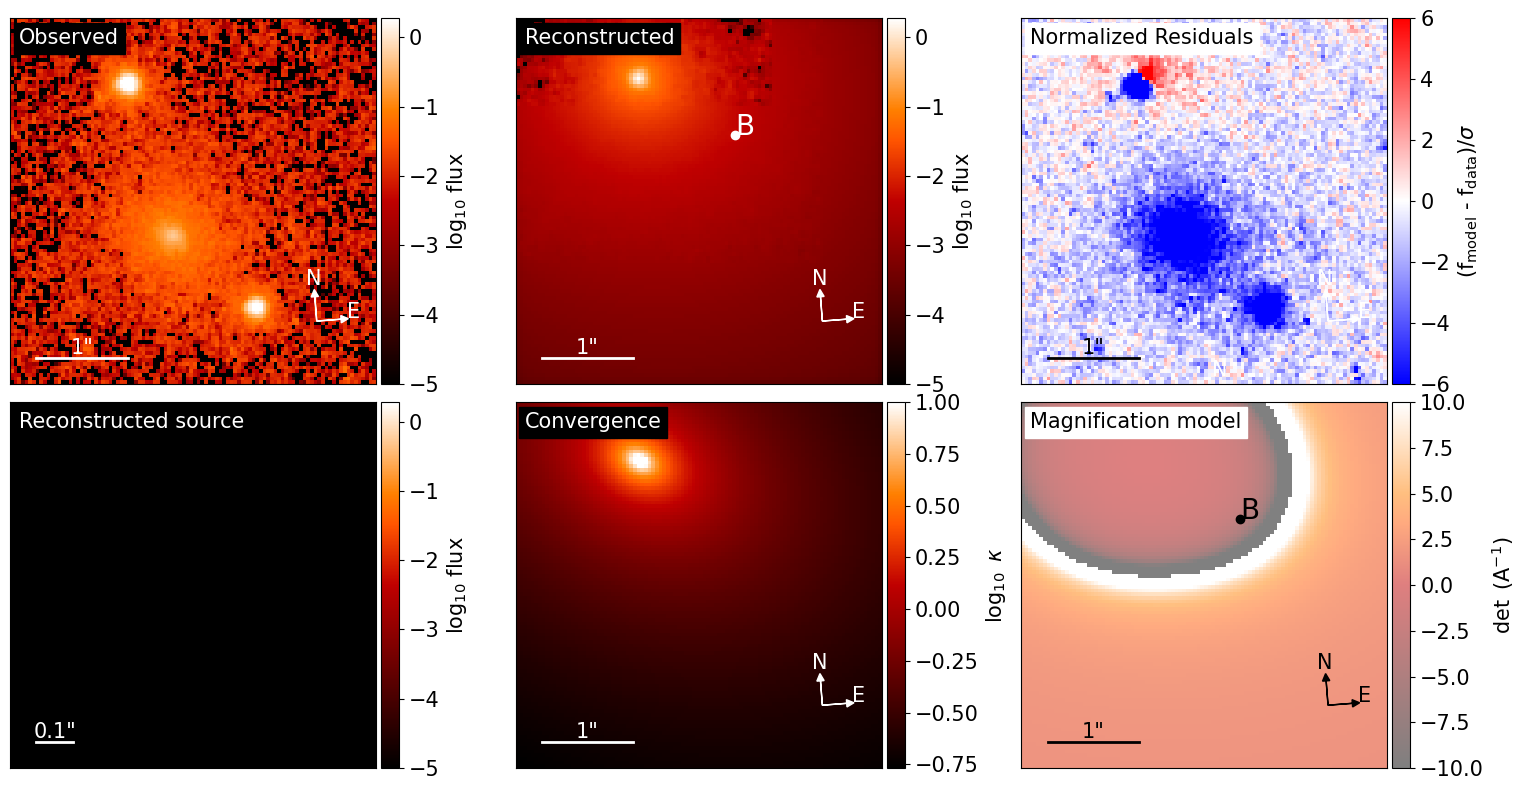

In [17]:
filter_index = 2
single_band = [multi_band_list[filter_index]]

# Create ModelPlot with single-band list
modelPlot = ModelPlot(single_band, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

# Plot
f, axes = modelPlot.plot_main()
f.show()

In [ ]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [False, False, True]}}], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],  # run PSO first band
    ['align_images', {'n_particles': 100, 'n_iterations': 1000, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': .1, 'delta_rot': .1,
                      'compute_bands': [True, False, False]}],  # align second image
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, False, True]},  # now we fit both bands jointly
                        }], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 50}],  # run PSO of both bands
    ['align_images', {'n_particles': 100, 'n_iterations': 1000, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': .1, 'delta_rot': .1,
                      'compute_bands': [False, True, False]}],  # align third image
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, True]},  # now we fit both bands jointly
                        }], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 50}],  # run PSO of three bands
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()

Computing the PSO ...


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Max iteration reached! Stopping.
-104.75443275205984 reduced X^2 of best position
-522305.6017017704 log likelihood
9972 effective number of data points
[{'theta_E': np.float64(1.5449835783514787), 'gamma': 2, 'e1': np.float64(-0.015885197995665554), 'e2': np.float64(-0.11131070146094209), 'center_x': np.float64(7.554111324188514), 'center_y': np.float64(-0.2135378948880509)}, {'gamma1': np.float64(0.050605272050670905), 'gamma2': np.float64(-0.0015586794939333071), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.0023788387369958076), 'n_sersic': np.float64(0.5909868857022261), 'e1': np.float64(0.04807742458866553), 'e2': np.float64(-0.0924548594733278), 'center_x': np.float64(7.745427000502188), 'center_y': np.float64(0.4106363171278806)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.002255502852352962), 'n_sersic': np.float64(2.412249802330406), 'e1': np.float64(-0.14415266459990467), 'e2': np.float64(-0.049094038152365446), 'center_x': np.float64(7.554

  4%|▍         | 43/1000 [00:44<16:32,  1.04s/it]


Converged after 43 iterations!
Best fit found:  -25616224.245179363 [0, 0, 0]
Shifts found:  [0, 0, 0]
44.585638999938965 time used for  Alignment fitting for band 1 ...
Align completed for band 1.
ra_shift: 0,  dec_shift: 0, phi_rot: 0
Computing the PSO ...


  0%|          | 0/50 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Sampling/Samplers/pso.py", line 472, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Sampling/likelihood.py", line 352, in logL
    return self.log_likelihood(kwargs_return, verbose=verbose)
           ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Sampling/likelihood.py", line 397, in log_likelihood
    logL_image, param = self.image_likelihood.logL(**kwargs_return)
                        ~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Sampling/Likelihoods/image_likelihood.py", line 74, in logL


PSO: Exception while calling your likelihood function:
  params: [np.float64(1.6152761086758596), np.float64(-0.14461651764694153), np.float64(0.06650450475699733), np.float64(0.13078230914760103), np.float64(-0.014692551766639653), np.float64(0.4637277372072423), np.float64(0.7603952653538107), np.float64(0.008206526327843085), np.float64(-0.1358633338994597), np.float64(0.20199570504361117), np.float64(2.5031564700313393), np.float64(-0.14082943435014997), np.float64(-0.08652268929652308), np.float64(7.477081345624003), np.float64(-0.29796787533123104), np.float64(1.0181808982767202), np.float64(5.88163162158785), np.float64(-0.08225182570181334), np.float64(0.0946293102630034), np.float64(7.17572177792211), np.float64(9.434586984837647), np.float64(-0.7443833323367588), np.float64(1.2065593283764073)]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

iteration of step 8 gave best reconstruction.
log likelihood before: -7181.253783008644 and log likelihood after: -6462.197049622815
iteration of step 4 gave best reconstruction.
log likelihood before: -6649.9342824994155 and log likelihood after: -5903.465590966812
-1.2365662640589627 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.2924394099245633
reduced chi^2 of data  1 =  1.1806931181933624


/home/rmbrady/miniconda3/envs/dolphin/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:138: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_in), origin="lower", **kwargs)
/home/rmbrady/miniconda3/envs/dolphin/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:159: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_out), origin="lower", **kwargs)
/home/rmbrady/miniconda3/envs/dolphin/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:200: RuntimeWarning: divide by zero encountered in log10
  np.log10(psf_variance_map * psf.kernel_point_source**2),
/home/rmbrady/miniconda3/envs/dolphin/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data - model),


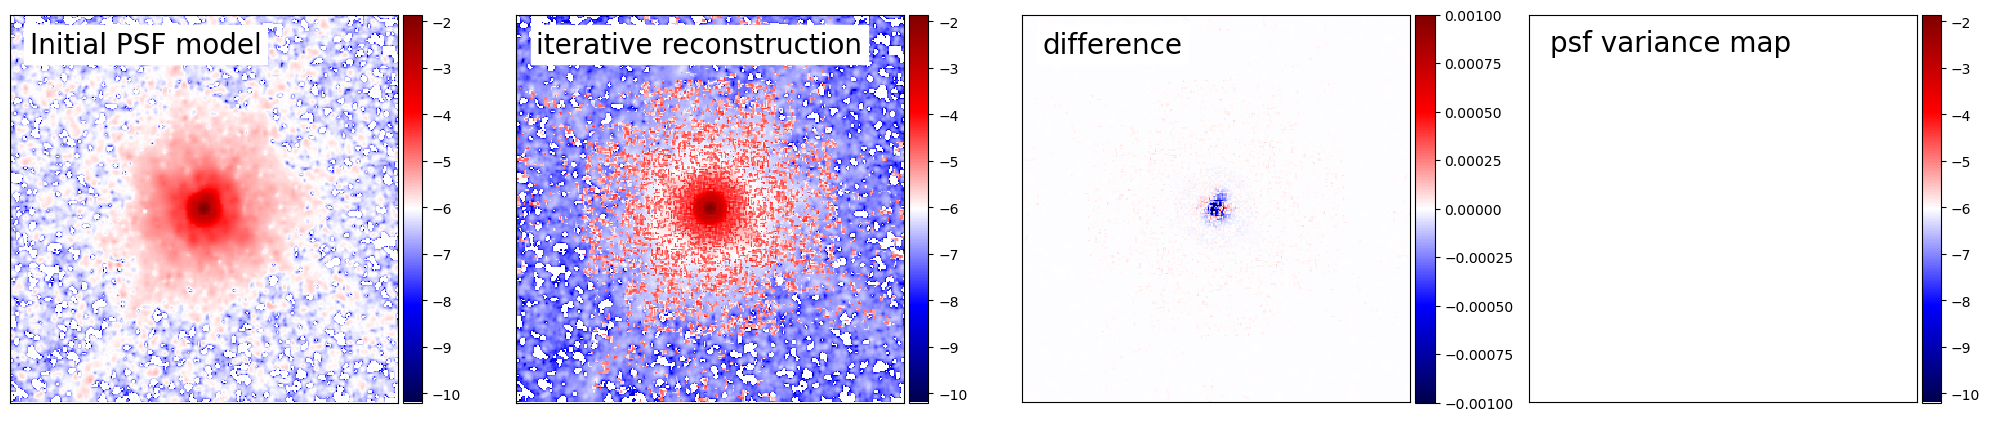

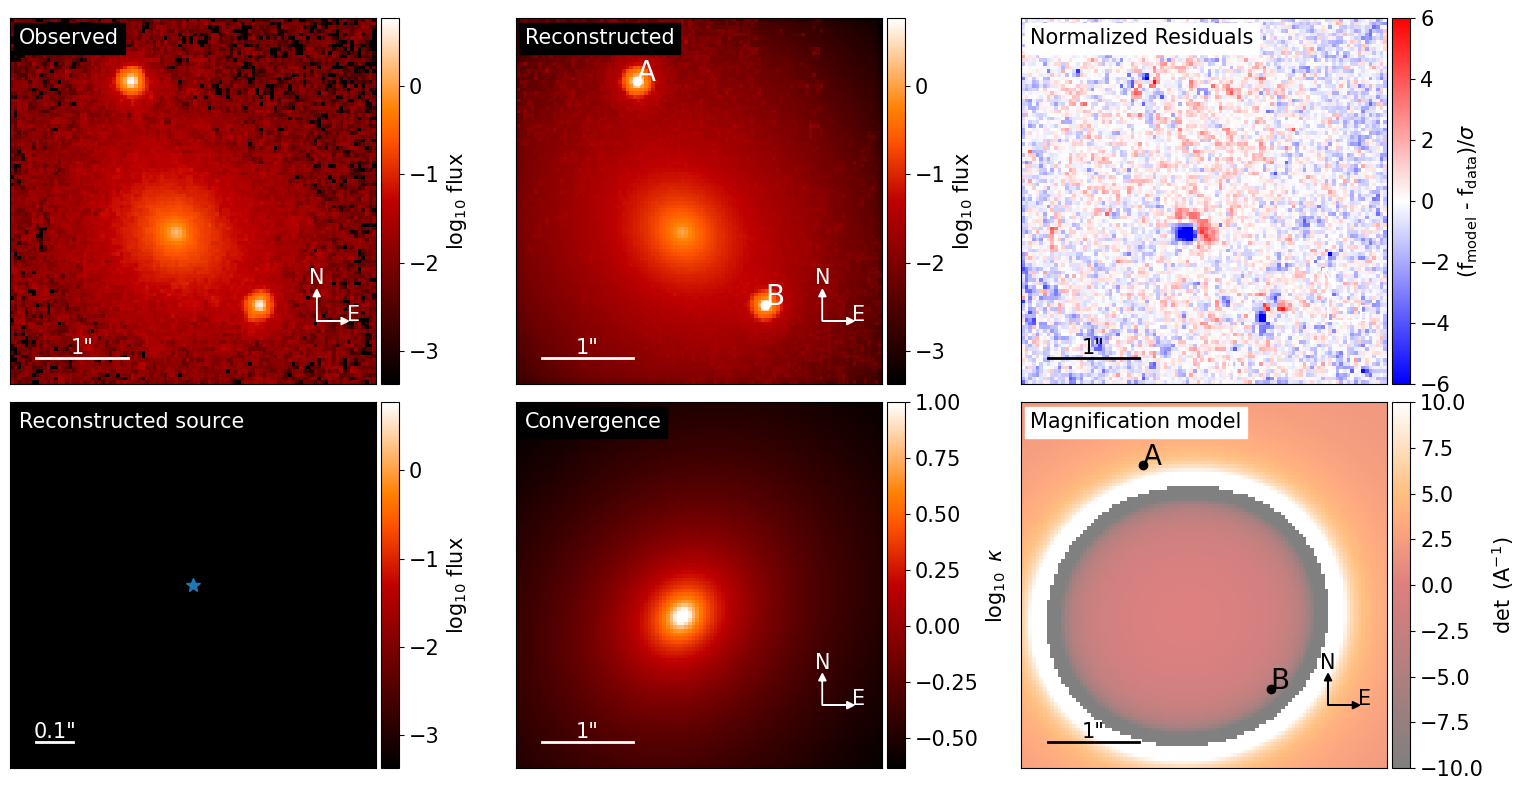

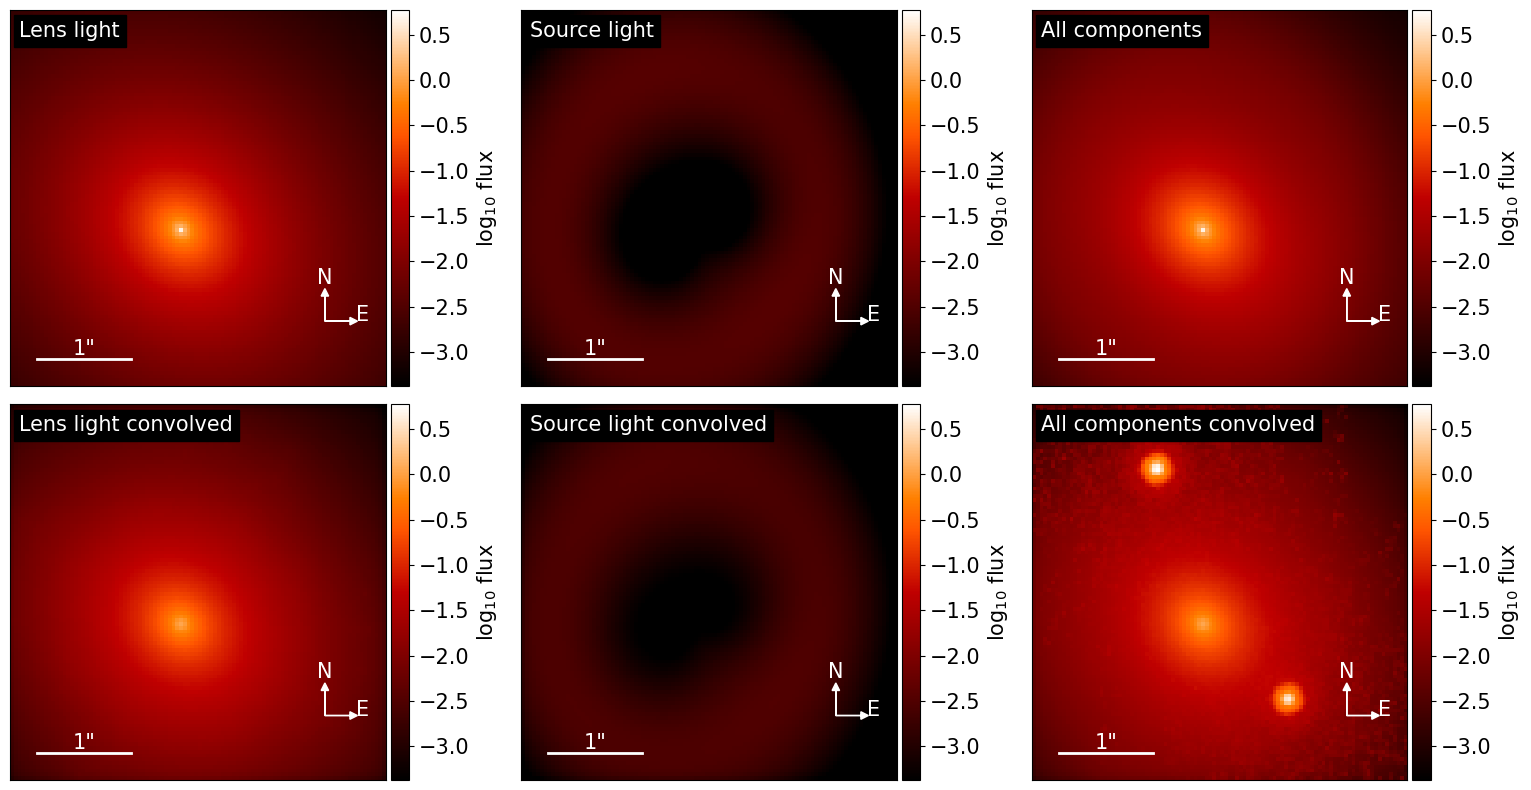

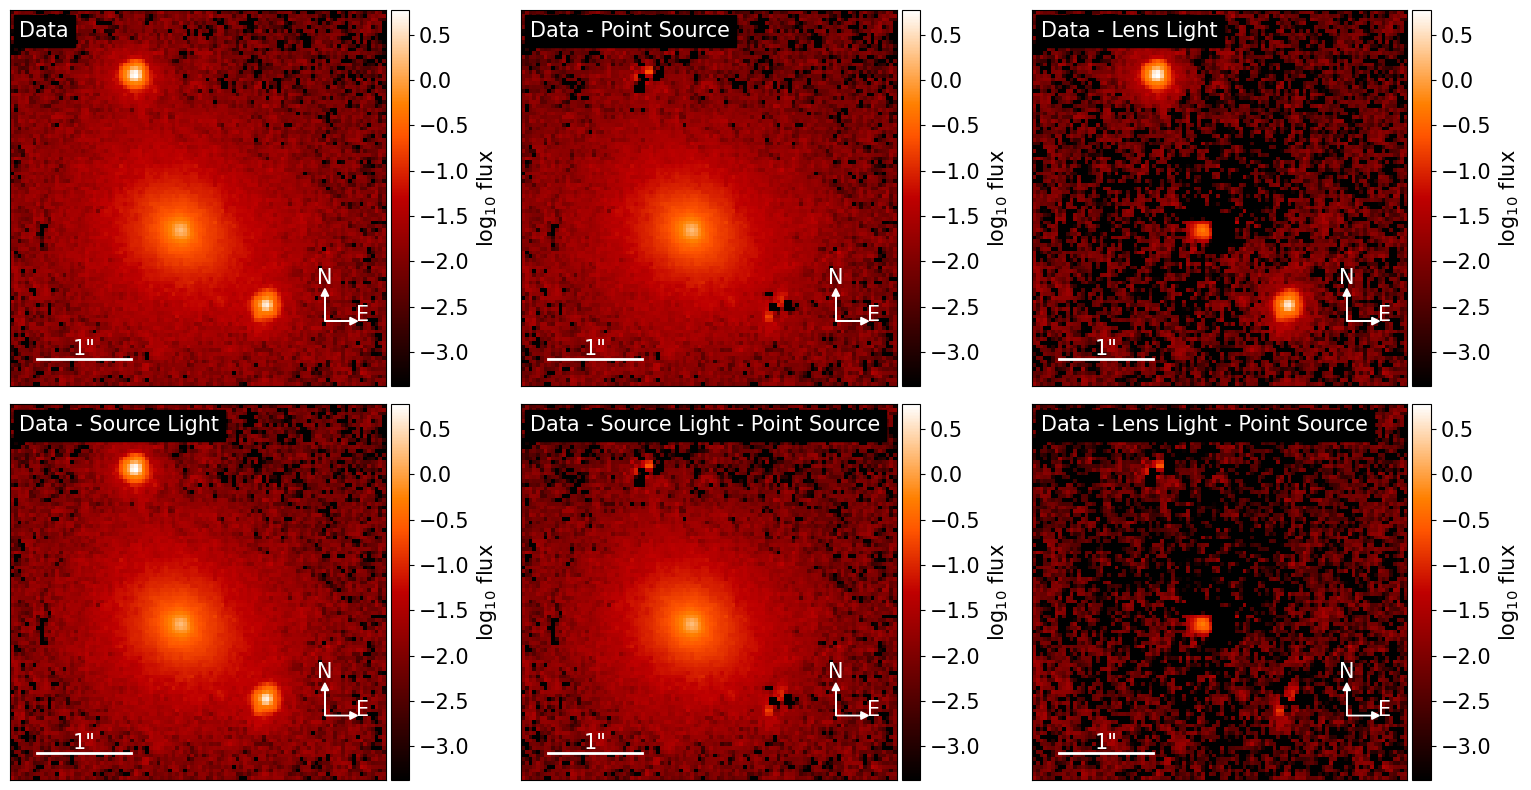

In [16]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
method_PSF_iteration = 'stack' #use 'STARRED' to use the STARRED method for PSF reconstruction or 'stack' to use the standard lenstronomy stacking method

kwargs_lbfgs = {'maxiter':1000}

kwargs_optax1 = {'max_iterations': 500, 'min_iterations': None,
                'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
                'progress_bar': True} 

if method_PSF_iteration == 'STARRED':
    kwargs_psf_iter = { 
                    'keep_psf_error_map': True, 
                    'psf_symmetry': 1, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 3, #we run STARRED more than once, to see if the chi2 keeps improving after redoing the linear inversion with the new PSF. 
                    'psf_iter_factor': 1, #We fully update the PSF at each iteration, if the fit improves
                    'kwargs_starred': {'verbose':True, 'lambda_scales':3, 'lambda_hf':3, #Choose regularisation parameters, lambda_scales and lambda_hf should be 2 or 3 if the noise is correctly scaled 
                                       'optim_list':['adabelief', 'adabelief'], 'kwargs_optim_list':[kwargs_optax1, kwargs_optax1],#Choose the optimisers to use, and pass the kwargs accordingly. One for the Moffat fit, one for the full PSF fit. 
                                       }, 
                    'use_starred': True, 
                    } 

else: 
    kwargs_psf_iter = {'stacking_method': 'median', 
                    'psf_symmetry': 4, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 50, 
                    'psf_iter_factor': 0.2
                    }

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

Computing the PSO ...


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


Max iteration reached! Stopping.
-1.239672112106707 reduced X^2 of best position
-12379.98554755363 log likelihood
19973 effective number of data points
[{'theta_E': np.float64(1.4812153312554548), 'gamma': 2, 'e1': np.float64(-0.012464443771095842), 'e2': np.float64(0.08787005449597732), 'center_x': np.float64(3.7995665308513877), 'center_y': np.float64(-0.35953866396990247)}, {'gamma1': np.float64(-0.052664220311354974), 'gamma2': np.float64(0.07037927770228397), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.4984608030877445), 'n_sersic': np.float64(0.5315810130922377), 'e1': np.float64(-0.07810088238694807), 'e2': np.float64(-0.11584926597631962), 'center_x': np.float64(3.8916957989668046), 'center_y': np.float64(-0.4216522020715435)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.6498153280204501), 'n_sersic': np.float64(2.499400707752541), 'e1': np.float64(0.00573139398754867), 'e2': np.float64(-0.08053120460331782), 'center_x': np.float64(3.7995665

100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Max iteration reached! Stopping.
-1.239672112106707 reduced X^2 of best position
-12379.98554755363 log likelihood
19973 effective number of data points
[{'theta_E': np.float64(1.4812153312554548), 'gamma': 2, 'e1': np.float64(-0.012464443771095842), 'e2': np.float64(0.08787005449597732), 'center_x': np.float64(3.7995665308513877), 'center_y': np.float64(-0.35953866396990247)}, {'gamma1': np.float64(-0.052664220311354974), 'gamma2': np.float64(0.07037927770228397), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.4984608030877445), 'n_sersic': np.float64(0.5315810130922377), 'e1': np.float64(-0.07810088238694807), 'e2': np.float64(-0.11584926597631962), 'center_x': np.float64(3.8916957989668046), 'center_y': np.float64(-0.4216522020715435)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.6498153280204501), 'n_sersic': np.float64(2.499400707752541), 'e1': np.float64(0.00573139398754867), 'e2': np.float64(-0.08053120460331782), 'center_x': np.float64(3.7995665

100%|██████████| 120/120 [08:59<00:00,  4.50s/it]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  100
Sampling iterations (in current run): 120
544.1028625965118 time taken for MCMC sampling
-1.1722874019089344 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.1831193734616772
reduced chi^2 of data  1 =  1.1614554303561917


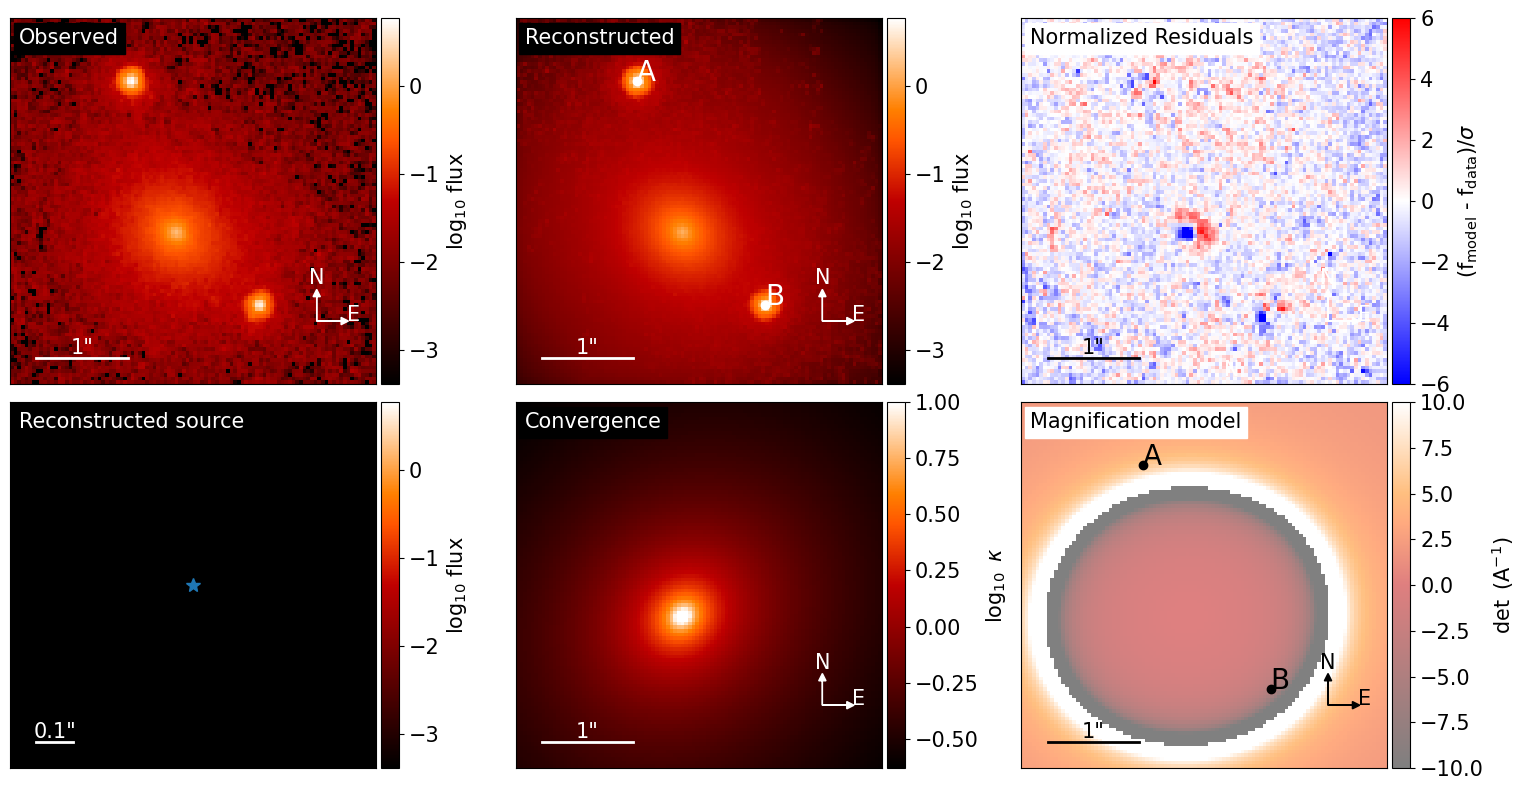

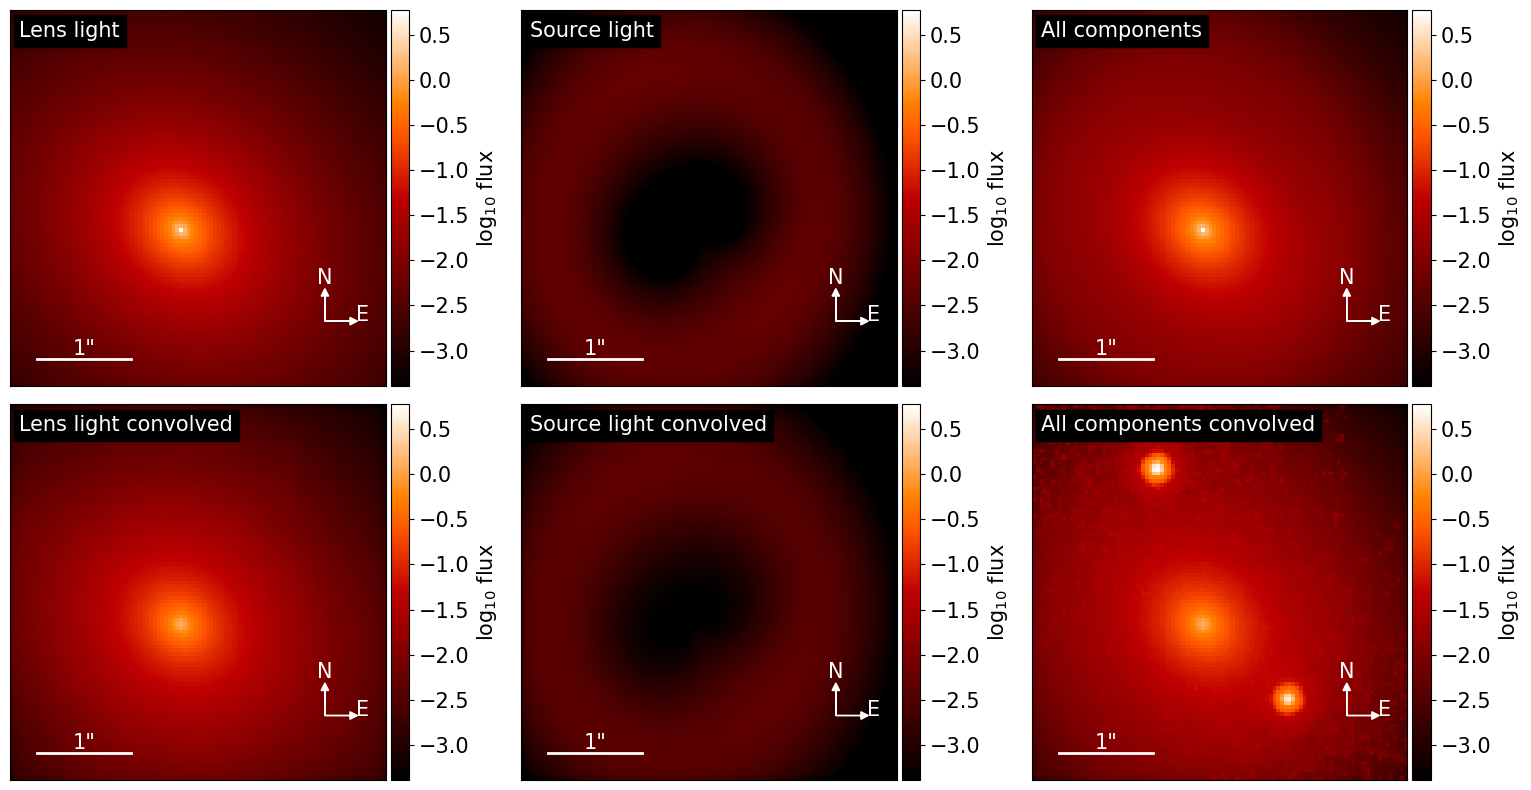

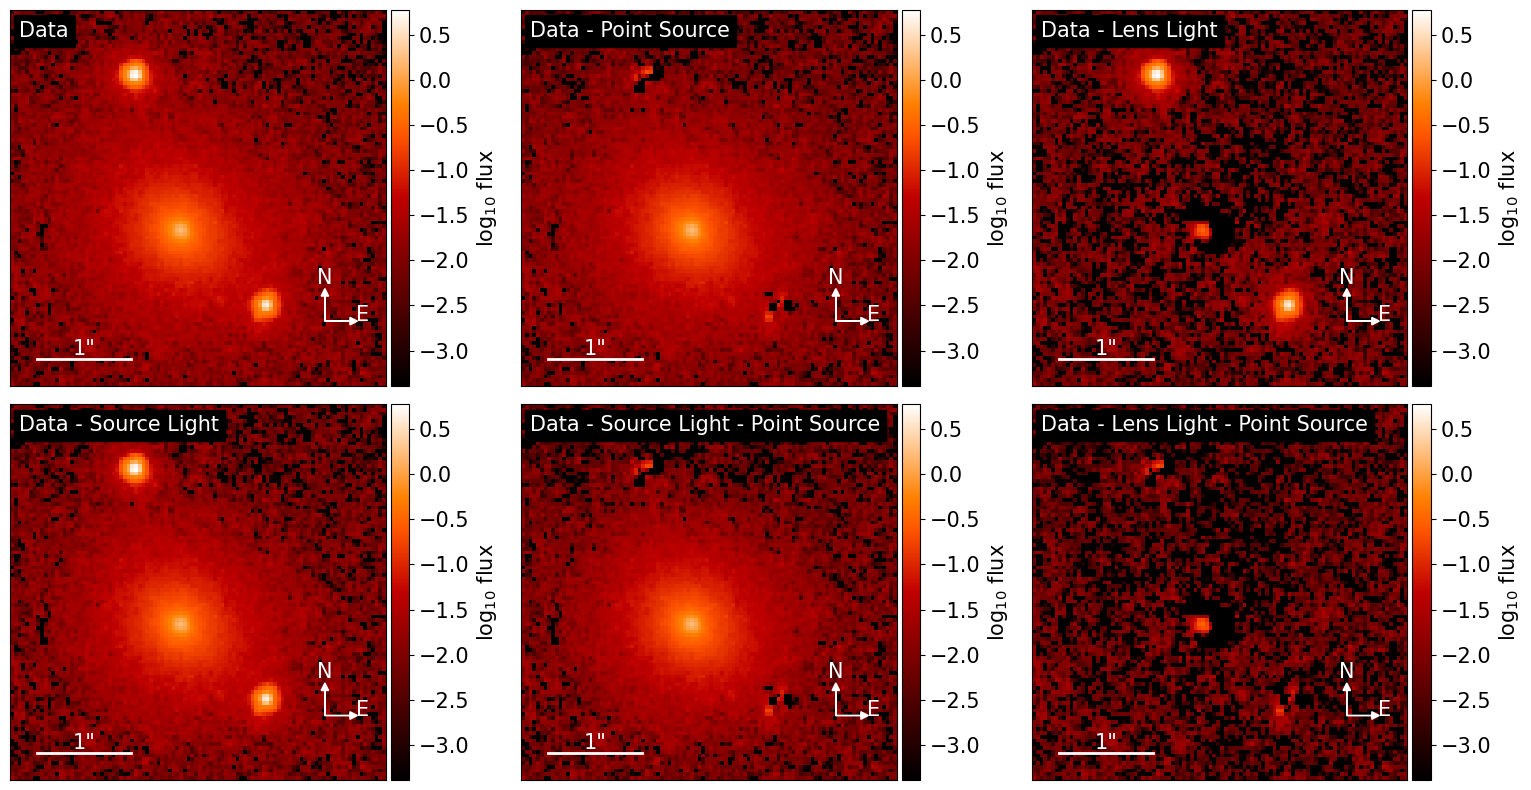

In [17]:
# run the fitting again with more iterations
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 20}],
                       ['psf_iteration', kwargs_psf_iter],
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 20}],
                       ['psf_iteration', kwargs_psf_iter],
                       ['MCMC', {'n_burn': 100, 'n_run': 20, 'walkerRatio': 10,'sigma_scale': .1}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
multi_band_list = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

In [34]:
print(chain_list[1][2])

['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'dec_image', 'dec_image']


ValueError: not enough values to unpack (expected 4, got 3)

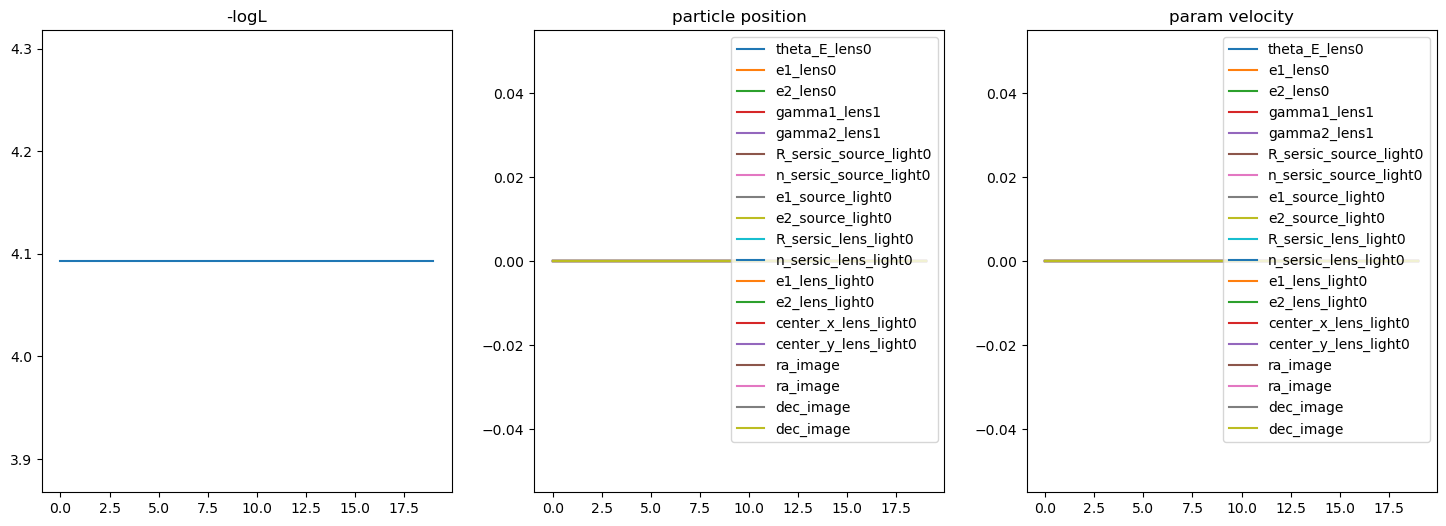

<Figure size 640x480 with 0 Axes>

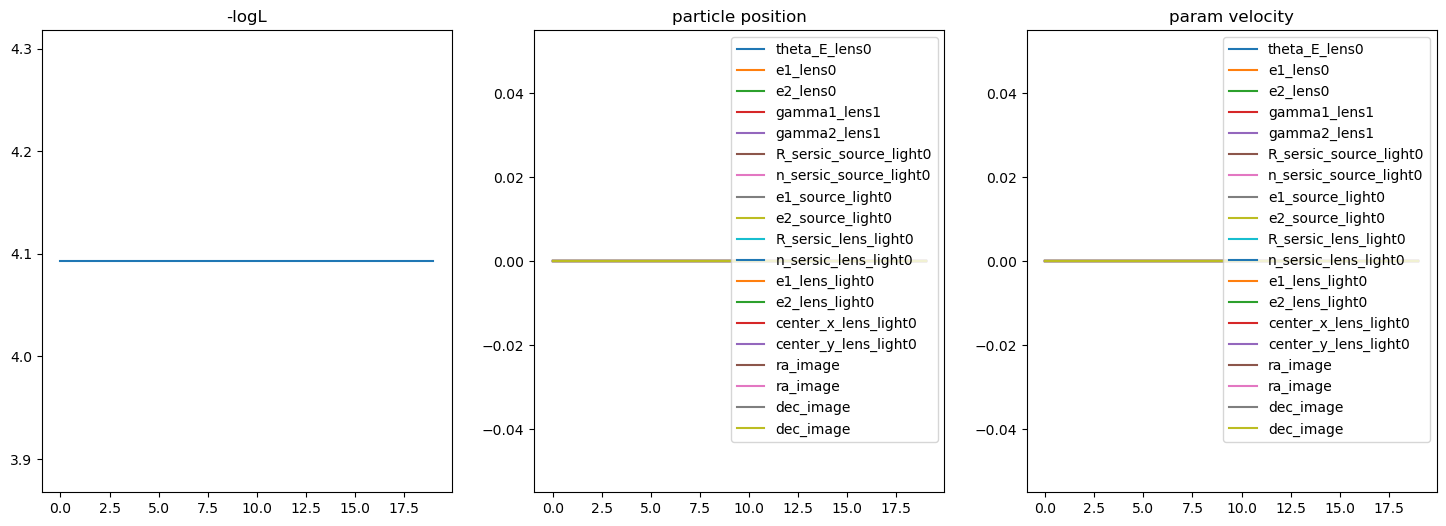

<Figure size 640x480 with 0 Axes>

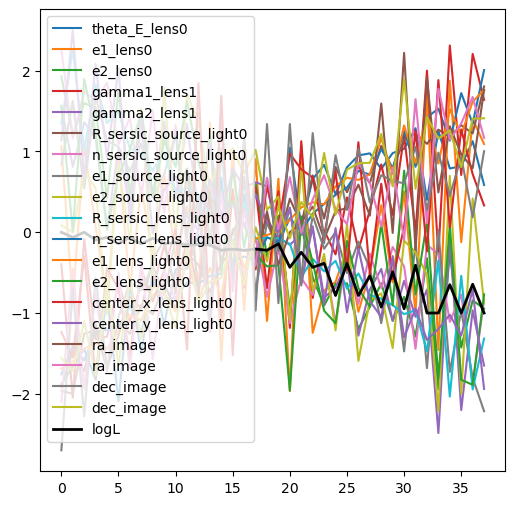

In [36]:
import corner
# analyze the PSO and MCMC chain
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

if samples_mcmc.size != 0:
    n, num_param = np.shape(samples_mcmc)
    plot = corner.corner(samples_mcmc[:, :9], labels=param_mcmc[:9], show_titles=True)
    plot = corner.corner(samples_mcmc[:, 9:], labels=param_mcmc[9:], show_titles=True)


In [37]:
# this is the linear inversion. The kwargs will be updated afterwards
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource

data_class = ImageData(**kwargs_data1)
lightModel = LightModel(lens_light_model_list)
pointSource = PointSource(point_source_list)

imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel,
                                point_source_class=pointSource, kwargs_numerics=kwargs_numerics1)

imageLinearFit = ImageLinearFit(data_class=data_class, psf_class=psf_class,
                        lens_light_model_class=lightModel,
                        point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics1)
lens_light_result = kwargs_result['kwargs_lens_light']
ps_result = kwargs_result['kwargs_ps']
image_reconstructed, _, _, _ = imageLinearFit.image_linear_solve(kwargs_lens_light=lens_light_result, kwargs_ps=ps_result)
# flux count in point source
image_ps = imageModel.point_source(ps_result)
ps_flux = ps_result[0]['point_amp']
print('Point Source Flux:', ps_flux)
# for point sources, the fluxes in 'point_amp' are equivalent to the flux counts in the image.
# The only difference is the smaller cutout size in the image

# flux count in host galaxy
image_host = imageModel.lens_surface_brightness(lens_light_result)
lens_flux = np.sum(image_host)
print('Host Galaxy Flux:', lens_flux)


Point Source Flux: [54.99556052 38.39400504]
Host Galaxy Flux: 229.11776860311713


In [42]:
# this is the linear inversion. The kwargs will be updated afterwards
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource

data_class = ImageData(**kwargs_data1)
lightModel = LightModel(lens_light_model_list)
pointSource = PointSource(point_source_list)

imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel,
                                point_source_class=pointSource, kwargs_numerics=kwargs_numerics2)

imageLinearFit = ImageLinearFit(data_class=data_class, psf_class=psf_class,
                        lens_light_model_class=lightModel,
                        point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics2)
lens_light_result = kwargs_result['kwargs_lens_light']
ps_result = kwargs_result['kwargs_ps']
image_reconstructed, _, _, _ = imageLinearFit.image_linear_solve(kwargs_lens_light=lens_light_result, kwargs_ps=ps_result)
# flux count in point source
image_ps = imageModel.point_source(ps_result)
ps_flux = ps_result[0]['point_amp']
print('Point Source Flux:', ps_flux)
# for point sources, the fluxes in 'point_amp' are equivalent to the flux counts in the image.
# The only difference is the smaller cutout size in the image

# flux count in host galaxy
image_host = imageModel.lens_surface_brightness(lens_light_result)
lens_flux = np.sum(image_host)
print('Host Galaxy Flux:', lens_flux)


Point Source Flux: [54.99556052 38.39400504]
Host Galaxy Flux: 229.11776860311713


In [ ]:
# plot posteriors on the flux calculations
from lenstronomy.Sampling.parameters import Param

param = Param(kwargs_model, kwargs_fixed_lens=[{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}],
               kwargs_fixed_lens_light=[{}], kwargs_fixed_source=[{}], kwargs_fixed_ps=[{}], **kwargs_constraints)

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

mcmc_new_list = []
labels_new = [r"Image 1 Flux", r"Image 2 Flux", r"Lens Flux"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments
    kwargs_out = param.args2kwargs(samples_mcmc[i])
    kwargs_light_lens_out = kwargs_out['kwargs_lens_light']
    kwargs_ps_out = kwargs_out['kwargs_ps']
    image_reconstructed, _, _, _ = imageLinearFit.image_linear_solve(kwargs_lens_light=kwargs_light_lens_out, kwargs_ps=kwargs_ps_out)

    image_ps = imageModel.point_source(kwargs_ps_out)
    flux_im1 = kwargs_ps_out[0]['point_amp'][0]
    flux_im2 = kwargs_ps_out[0]['point_amp'][1]

    image_lens = imageModel.lens_surface_brightness(kwargs_light_lens_out, k=0)
    flux_lens = np.sum(image_lens)

    mcmc_new_list.append([flux_im1, flux_im2, flux_lens])

plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)